In [1]:
import keras
import datetime
import tensorflow                       as tf
from tensorflow.keras.callbacks         import TensorBoard
from tensorflow.keras.layers            import Input, Lambda, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate,BatchNormalization
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam
from keras.utils                        import plot_model
from tensorflow.keras                   import layers, models
import sys
import os

2024-10-25 11:36:12.767850: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 11:36:12.774811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 11:36:12.783006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 11:36:12.785382: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 11:36:12.791643: I tensorflow/core/platform/cpu_feature_guar

# 1. Setting

In [2]:
# Files path
directory_one = os.path.abspath("/home/guiomar/Desktop/CODES/DLCODES-VER2")
directory_two = os.path.abspath("/home/guiomar/Desktop/CODES/DLCODES")

# Add directory to sys.path
sys.path.append(directory_one)
sys.path.append(directory_two)

# import scripts
import param                        # prameters for Dataset mainly
import config                       # hiperparameters for the model
from process_data        import *   # dataset script
from tools               import *   # predict, plot performance script,etc

# Set the number of cores

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
num_threads = param.n_threads  
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)



# 2. Learning rate schedules

In [4]:
# Used in the model
'''
def decayed_learning_rate(step):
    return initial_learning_rate * decay_rate ^ (step / decay_steps)
'''
def lr_rate(train_data,epoch=config.num_epochs,batch_size=config.batch_size,lr=config.lr_init,decay_rate=0.2):
    
        n_steps = epoch * math.ceil(len(train_data) / batch_size)
        scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=n_steps, decay_rate=decay_rate)
    
        return scheduled_learning_rate

In [ ]:
class MultiFactorScheduler:
    def __init__(self, step, factor, base_lr=config.lr_init):
        self.step    = step
        self.factor  = factor
        self.base_lr = base_lr
        
    def __call__(self, epoch):
        if epoch in self.step:
            self.base_lr = self.base_lr * self.factor
            return self.base_lr
        else:
            return self.base_lr

In [ ]:
class Exponential_decay:
    def __init__(self,base_lr=config.lr_init,decay_rate=0.05):
       
        self.decay_rate = decay_rate
        self.base_lr = base_lr

    def __call__(self, epoch):
        return self.base_lr * np.exp(-self.decay_rate * epoch)

# 3. U-Net model 

In [5]:
class U_Net:
    
    def __init__(self,geo_train,flow_train,geo_valid,flow_valid,geo_tests,flow_tests):
        
        # Hiperparameters from config.py
        
        self.w             = config.img_width
        self.h             = config.img_height
        self.num_classes   = config.num_classes
        self.epoch         = config.num_epochs 
        self.batch_size    = config.batch_size
        self.patience      = config.patience
        self.loss          = config.loss
        self.metrics       = config.metric
        
        # Data  
        self.train_data     =geo_train
        self.val_data       =geo_valid
        self.train_data_sol =flow_train
        self.val_data_sol   =flow_valid
        self.test_data      =geo_tests
        self.test_data_sol  =flow_tests
        self.ch             =self.train_data.shape[3]
        
    # Encode block with batchnormalization 
    def encoder_block(self,num_filters,x):
         x = Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
         x = BatchNormalization()(x)
    
         x = Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
         skip = BatchNormalization()(x)
        
         pool=MaxPooling2D((2,2))(skip)
         return pool,skip
        
    # Decode block  
    def decoder_block(self,num_filters,x1,x2):
        
        x=Conv2DTranspose(num_filters,(2,2),strides=(2, 2),padding="same")(x1) # remark: if it's used padding=valid, apply copy and crop the skip features
        x=concatenate([x,x2])
        x=Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
        x=Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
        return x
        
    # U_NET built
    def build(self):

         image_input = Input((self.h, self.w, self.ch))
        
         #contracting Path
         pool1,skip1 = self.encoder_block(64,image_input)
         pool2,skip2 = self.encoder_block(128,pool1)
        
         pool3,skip3 = self.encoder_block(256,pool2)
         pool4,skip4 = self.encoder_block(512,pool3)
         

         # Bottleneck

         b = Conv2D(1024, (3,3), activation='relu', padding='same')(pool4)
         b = Conv2D(1024, (3,3), activation='relu', padding='same')(b)
         
         # Expansive Path 
         x5 = self.decoder_block(512,b, skip4) 
         x6 = self.decoder_block(256,x5, skip3) 
         
         x7 = self.decoder_block(128,x6, skip2) 
         x8 = self.decoder_block(64,x7, skip1) 
    
         # Output the last block
         output=Conv2D(self.num_classes, (1, 1), activation="relu", padding="same")(x8)  # one channel correspond to one class
        
         # Define model
         model = models.Model(image_input, output, name="U-Net")
         model.summary()
         return model  
        
    # Callback early stopping    
    def early_stopping(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.patience, restore_best_weights=True)
        return early_stopping
        
    # Compile and fit the model
    def execute(self):
        
            model=self.build()
            plot_model(model, to_file="U_Net_architecture.png")
        
            #steps= [y for y in range(1,self.epoch) if (y % 10 ==0)]
            #scheduler = MultiFactorScheduler(step=steps, factor=0.9, base_lr=self.lr_init)
            #scheduler=Exponential_decay()
        
            scheduler=lr_rate(self.train_data)
            checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_best.weights.h5",save_weights_only=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
        
            model.compile(optimizer=optimizer, loss=self.loss, metrics=[self.metrics])
        
            save_callback = SaveOutputCallback('output_training.txt')
    
            model_fitted= model.fit(self.train_data,self.train_data_sol,
                                    batch_size=self.batch_size,validation_data=(self.val_data, self.val_data_sol),
                                    epochs=self.epoch,callbacks=[self.early_stopping(),checkpoint_cb,save_callback])
        
            callbacks = [tf.keras.callbacks.ModelCheckpoint("Unet.keras",save_best_only=True)]
            model.save('Completed_Model.h5')
            return model_fitted
   

# 4. Loading dataset


****** 		 Loaded  500 from  /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Geometry  *******


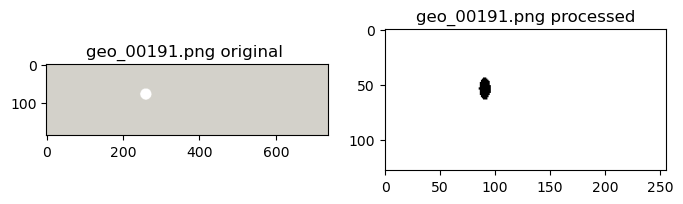


****** 		 Loaded  500 from  /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Magnitude  *******


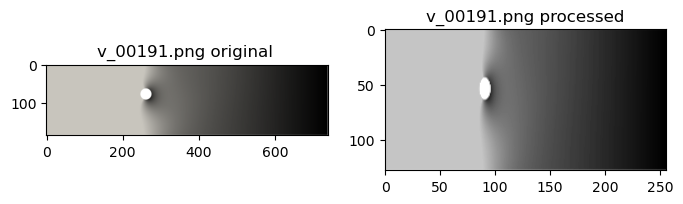

				==============>  Processed Magnitude done!


In [6]:
# create an object from Dataset class ( from process_data script)
D=Dataset(param.img_height,param.img_width,param.list_paths,param.train_size,param.valid_size,param.tests_size, param.opt_for_data,param.opt_process)

# get train, valid and test dataset
geo_train, geo_valid, geo_tests, flow_train, flow_valid, flow_tests=D.datasets_for_model()

# 5. Calling the U-Net model

2024-09-17 11:39:57.579898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-17 11:39:57.600539: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 128,   │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,038,273 (118.40 MB)

 Trainable params: 31,034,433 (118.39 MB)

 Non-trainable params: 3,840 (15.00 KB)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 83s 13s/step - loss: 0.2938 - mean_absolute_error: 0.4376 - val_loss: 0.2835 - val_mean_absolute_error: 0.4487
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 78s 13s/step - loss: 0.1983 - mean_absolute_error: 0.3597 - val_loss: 0.2835 - val_mean_absolute_error: 0.4487
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 77s 13s/step - loss: 0.1502 - mean_absolute_error: 0.2940 - val_loss: 0.2835 - val_mean_absolute_error: 0.4487
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 77s 13s/step - loss: 0.0847 - mean_absolute_error: 0.2065 - val_loss: 0.2835 - val_mean_absolute_error: 0.4487
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 76s 13s/step - loss: 0.0640 - mean_absolute_error: 0.1783 - val_loss: 0.2835 - val_mean_absolute_error: 0.4487
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 76s 13s/step - loss: 0.0478 - mean_absolute_error: 0.1207 - val_loss: 0.2835 - val_mean_absolute_error: 0.4487
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 78s 13s/step - loss: 0.0472 - mean_absolute_error: 0.1138 - val_loss: 0.283


 *** *** *** Training time was  1:52:19.178351 .


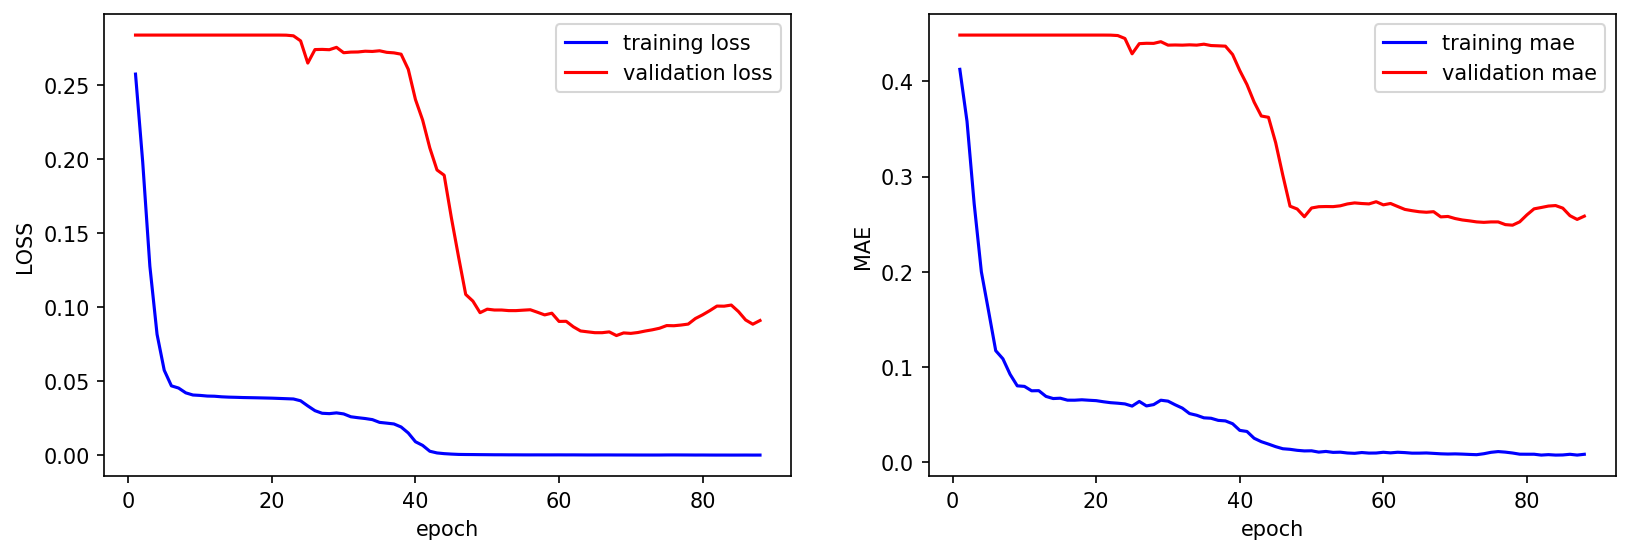

In [8]:
M=U_Net(geo_train,flow_train,geo_valid,flow_valid,geo_tests,flow_tests)
start=time.time()
model=M.execute()
end = time.time()
print('\n *** *** *** Training time was ',str(datetime.timedelta(seconds=end-start)),'.')
# Plotting the performance
plot(model)

# 6. Loading Model 

In [9]:
path='/home/guiomar/Desktop/CODES/DLCODES-VER2/my_best.weights.h5'
M=U_Net(geo_train,flow_train,geo_valid,flow_valid,geo_tests,flow_tests)
model=M.build()
model.load_weights(path)

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 256,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 128,   │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 128,   │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │      1,024 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │      1,024 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 32,    │  1,180,160 │ max_pooling2d_6[

 Total params: 31,038,273 (118.40 MB)

 Trainable params: 31,034,433 (118.39 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [10]:
y,e,mse=prediction(model,geo_tests,flow_tests)


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


sample 61


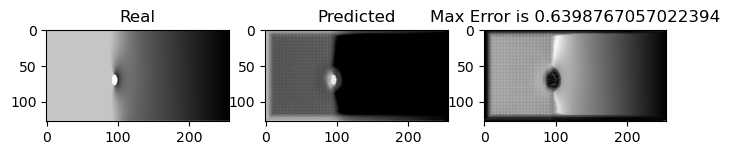

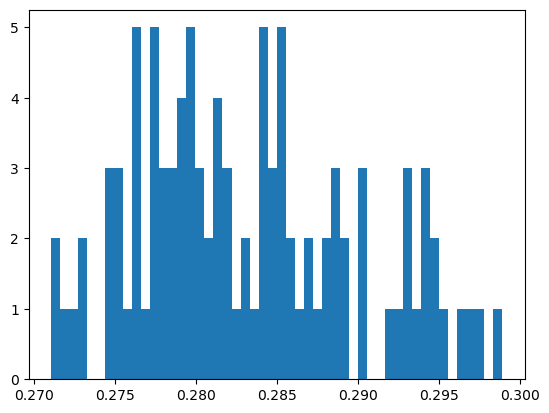

In [11]:
show_predict(y,flow_tests,e,mse)